# Dataset Cleaning
This notebook pollutes a train set by randomly flipping labels, then prioritizes train instances to check to fix them.

In [1]:
import os
import sys
sys.path.insert(0, os.getcwd() + '/../')  # for scripts
sys.path.insert(0, os.getcwd() + '/../../')  # for util

from scripts.cleaning import noise_detection
data_dir = '../../data'

/Users/Jonny/Documents/research/interpretability/classification/trees/myenv/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


train instances: 26215
test instances: 6554
num noisy labels: 10486

Before noise:
model (CatBoostClassifier)
test set acc: 0.941562
missed test instances (383)
test log loss: 0.18010
test auroc: 0.820

After noise:
model (CatBoostClassifier)
test set acc: 0.883583
missed test instances (763)
test log loss: 0.55343
test auroc: 0.547


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


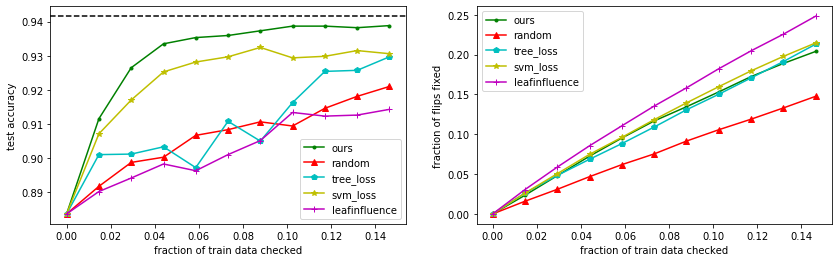

In [2]:
noise_detection(model_type='cb', encoding='tree_output', dataset='amazon', n_estimators=100, random_state=1, inf_k=0,
                data_dir=data_dir, svm_loss=True)

train instances: 32561
test instances: 16281
num noisy labels: 13024

Before noise:
model (CatBoostClassifier)
test set acc: 0.868313
missed test instances (2144)
test log loss: 0.28596
test auroc: 0.923

After noise:
model (CatBoostClassifier)
test set acc: 0.806277
missed test instances (3154)
test log loss: 0.59129
test auroc: 0.826


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


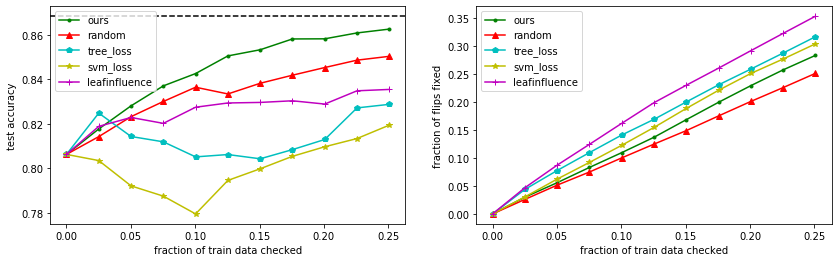

In [4]:
noise_detection(model_type='cb', encoding='tree_output', dataset='adult', n_estimators=100, random_state=1, inf_k=0,
                data_dir=data_dir, svm_loss=True)

train instances: 3019
test instances: 755
num noisy labels: 800

Before noise:
model (CatBoostClassifier)
test set acc: 0.923179
missed test instances (58)
test log loss: 0.19990
test auroc: 0.969

After noise:
model (CatBoostClassifier)
test set acc: 0.855629
missed test instances (109)
test log loss: 0.42177
test auroc: 0.923


100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


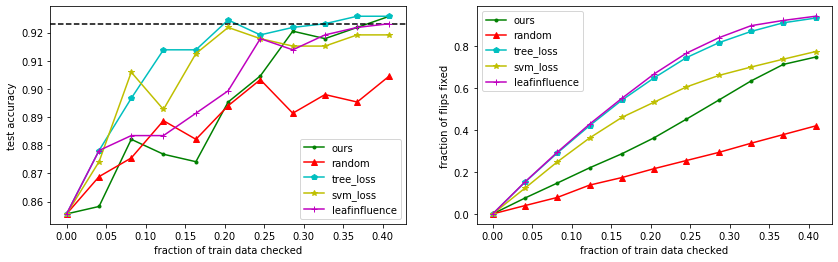

In [3]:
noise_detection(model_type='cb', encoding='tree_output', dataset='medifor2', n_estimators=100, random_state=1, inf_k=0,
                data_dir=data_dir, svm_loss=True)

train instances: 26215
test instances: 6554
sum before: 24711
ones flipped: 9871
zeros flipped: 615
sum after: 15455
num noisy labels: 10486

Before noise:
model (CatBoostClassifier)
train set acc: 0.946176
missed train instances (1411)
train log loss: 0.16173
train auroc: 0.873
test set acc: 0.941562
missed test instances (383)
test log loss: 0.18010
test auroc: 0.820

After noise:
model (CatBoostClassifier)
train set acc: 0.619111
missed train instances (9985)
train log loss: 0.64896
train auroc: 0.657
test set acc: 0.883583
missed test instances (763)
test log loss: 0.55343
test auroc: 0.547


100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


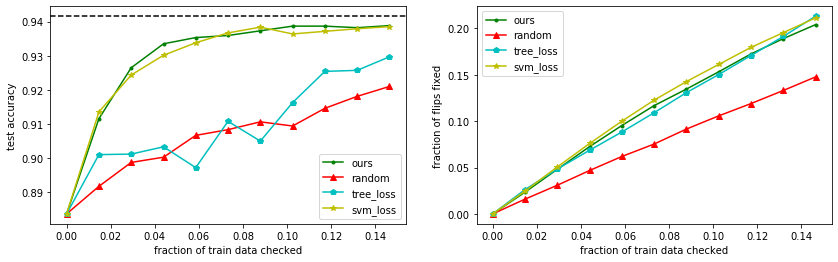

In [2]:
noise_detection(model_type='cb', encoding='tree_output', dataset='amazon', n_estimators=100, random_state=1, inf_k=None,
                data_dir=data_dir, svm_loss=True)

train instances: 32561
test instances: 16281
sum before: 7841
ones flipped: 2998
zeros flipped: 10026
sum after: 14869
num noisy labels: 13024

Before noise:
model (CatBoostClassifier)
train set acc: 0.882590
missed train instances (3823)
train log loss: 0.26534
train auroc: 0.937
test set acc: 0.868313
missed test instances (2144)
test log loss: 0.28596
test auroc: 0.923

After noise:
model (CatBoostClassifier)
train set acc: 0.607997
missed train instances (12764)
train log loss: 0.65584
train auroc: 0.654
test set acc: 0.806277
missed test instances (3154)
test log loss: 0.59129
test auroc: 0.826


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


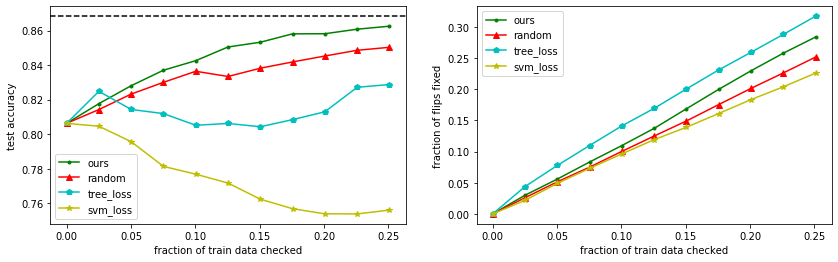

In [3]:
noise_detection(model_type='cb', encoding='tree_output', dataset='adult', n_estimators=100, random_state=1, inf_k=None,
                data_dir=data_dir, svm_loss=True)

train instances: 3774
test instances: 17421
sum before: 1406
ones flipped: 594
zeros flipped: 916
sum after: 1728
num noisy labels: 1510

Before noise:
model (LGBMClassifier)
train set acc: 1.000000
train log loss: 0.02060
train auroc: 1.000
test set acc: 0.817634
test log loss: 0.58381
test auroc: 0.711

After noise:
model (LGBMClassifier)
train set acc: 0.956280
train log loss: 0.36014
train auroc: 0.993
test set acc: 0.530394
test log loss: 0.71881
test auroc: 0.477


100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


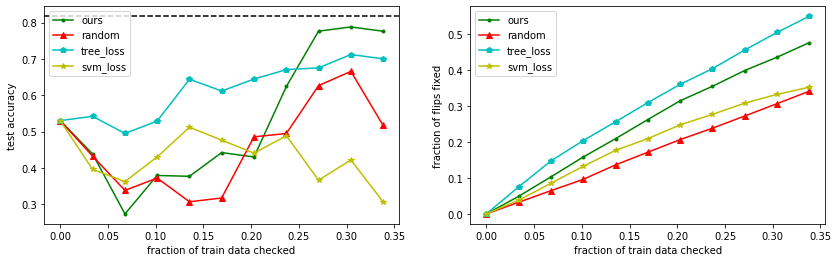

In [6]:
noise_detection(model_type='lgb', encoding='tree_path', dataset='medifor', n_estimators=100, random_state=69, inf_k=None,
                data_dir=data_dir, svm_loss=True)

train instances: 3019
test instances: 755
sum before: 1125
ones flipped: 304
zeros flipped: 496
sum after: 1317
num noisy labels: 800

Before noise:
model (LGBMClassifier)
train set acc: 1.000000
train log loss: 0.01417
train auroc: 1.000
test set acc: 0.925828
test log loss: 0.20638
test auroc: 0.974

After noise:
model (LGBMClassifier)
train set acc: 0.968533
train log loss: 0.25023
train auroc: 0.996
test set acc: 0.858278
test log loss: 0.40438
test auroc: 0.922


100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


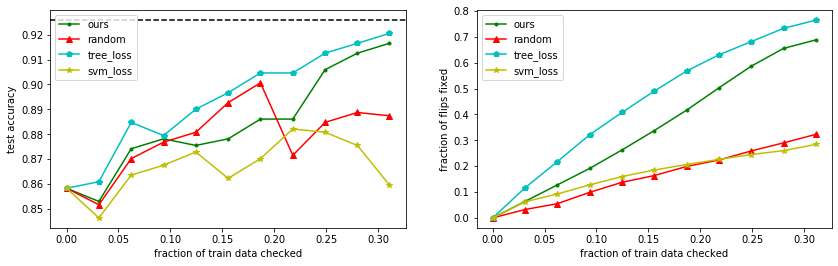

In [4]:
noise_detection(model_type='lgb', encoding='tree_output', dataset='medifor2', n_estimators=100, random_state=1, inf_k=None,
                data_dir=data_dir, svm_loss=True)

train instances: 13936
test instances: 3485
sum before: 2612
ones flipped: 1306
zeros flipped: 5662
sum after: 6968
num noisy labels: 6968

Before noise:
model (LGBMClassifier)
train set acc: 0.966777
train log loss: 0.10226
train auroc: 0.995
test set acc: 0.934290
test log loss: 0.16958
test auroc: 0.967

After noise:
model (LGBMClassifier)
train set acc: 0.819317
train log loss: 0.57978
train auroc: 0.907
test set acc: 0.496987
test log loss: 0.70561
test auroc: 0.510


100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


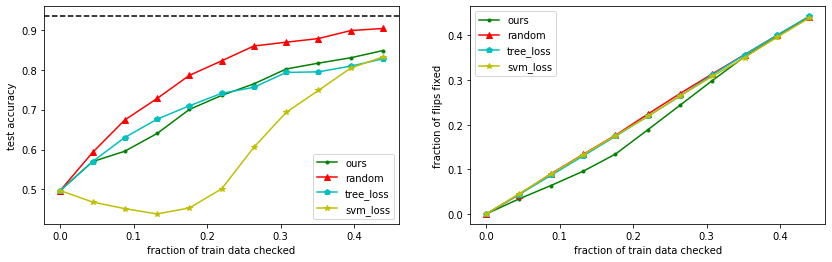

In [11]:
noise_detection(model_type='lgb', encoding='tree_path', dataset='medifor3', n_estimators=100, random_state=2, inf_k=None,
                data_dir=data_dir, svm_loss=True)

train instances: 455
test instances: 114
sum before: 285
ones flipped: 56
zeros flipped: 34
sum after: 263
num noisy labels: 90

Before noise:
model (LGBMClassifier)
train set acc: 1.000000
train log loss: 0.00071
train auroc: 1.000
test set acc: 0.973684
test log loss: 0.11555
test auroc: 0.992

After noise:
model (LGBMClassifier)
train set acc: 1.000000
train log loss: 0.02992
train auroc: 1.000
test set acc: 0.850877
test log loss: 0.30027
test auroc: 0.930


100%|██████████| 10/10 [00:01<00:00,  8.32it/s]


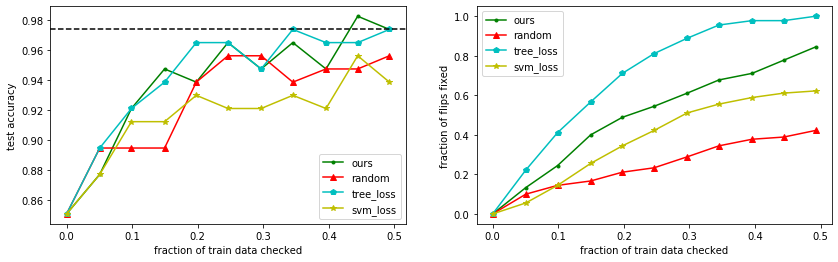

In [8]:
noise_detection(model_type='lgb', encoding='tree_path', dataset='breast', n_estimators=100, random_state=1, inf_k=None,
                data_dir=data_dir, svm_loss=True)